# **Setting**

In [1]:
#%matplotlib inline
import numpy as np
import pandas as pd
import os
import tqdm
import math

from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from math import sqrt
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from scipy.spatial import distance
import matplotlib.pyplot as plt
import warnings


from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = 999


In [2]:
#파라미터 설정
data_path = 'storage/shop_data/interaction_data.csv'
_num_recommendations=10
item_id_var = 'ITEM_ID'
user_id_var = 'USER_ID'
event = 'EVENT_TYPE'
timestamp = 'TIMESTAMP'
user_var = ['USER_NAME','AGE','GENDER']
item_var = ['ITEM_NAME','CATEGORY_L1','STYLE','ITEM_DESCRIPTION','PRICE']

In [3]:
data_path = 'storage/movie_data/interaction_data.csv'
_num_recommendations=10
item_id_var = 'ITEM_ID'
user_id_var = 'USER_ID'
event = 'EVENT_TYPE'
timestamp = 'TIMESTAMP'
user_var = []
item_var = ['ITEM_NAME', 'CATEGORY_L1']

In [3]:
#데이터 살펴보기
data= pd.read_csv(data_path)
data.head(3)
data[item_id_var] = data[item_id_var].astype(str)
data[user_id_var] = data[user_id_var].astype(str)

In [4]:
#user 데이터셋 생성
user_df = data[[user_id_var]+user_var].drop_duplicates(user_id_var).reset_index(drop=True)

#item 데이터셋 생성
item_df = data[[item_id_var]+item_var].drop_duplicates(item_id_var).reset_index(drop=True)

#interaction 데이터셋 생성
interaction_df=data[[item_id_var, user_id_var, event, timestamp]]
if data[event].dtypes != float:
    interaction_df.loc[:, event] = 5

In [5]:
item_df

,ITEM_ID,ITEM_NAME,CATEGORY_L1,STYLE,ITEM_DESCRIPTION,PRICE
0,26bb732f-9159-432f-91ef-bad14fedd298,Kettle,housewares,kitchen,Unparalleled for every kitchen,58.99
1,dc073623-4b95-47d9-93cb-0171c20baa04,Groovy Glasses,accessories,glasses,These groovy glasses for women are perfect everywhere,131.99
2,31efcfea-47d6-43f3-97f7-2704a5397e22,Gainsboro Sneakers,footwear,sneaker,Ultrahip pair of gainsboro sneakers for walking in a new city,209.99
3,20fb1207-9bb2-4e68-9d86-b0368d55c82f,Christmas Wreath,floral,wreath,Christmas wreath grown sustainably on our organic farms,96.99
4,610d0b43-fbc2-481c-b2cb-570a4f8c214c,Christmas Wreath,floral,wreath,Christmas wreath grown sustainably on our organic farms,147.99
...,...,...,...,...,...,...
2444,079f8824-e91b-40ea-b159-5f7d0a9d9124,Christmas Figurines,seasonal,christmas,A favorite for the holidays,106.99
2445,c964048a-2f3c-4085-ba68-78023737ae2f,Rattan Basket,homedecor,decorative,This rattan basket will delight everyone,17.99
2446,9a905b67-bcca-4445-aeea-ae3146e1cf0d,First-Rate Necklace,jewelry,necklace,First-rate necklace for women,145.99
2447,d0e671f9-495c-4aa3-ac49-019e66feb5be,Sans Pareil Necklace,jewelry,necklace,Sans pareil necklace for women,142.99


# **MF-SVD**

In [6]:
def calculate_similarity(interaction_df, latent_features=50):
    pt = pd.pivot_table(index=user_id_var, columns=item_id_var, values=event, data=interaction_df, fill_value=0) #interaction데이터 pivot table 생성
    pt_m = pt.to_numpy()                                     # pivot table 생성
    user_ratings_mean = np.mean(pt_m, axis = 1)              # 사용자별 rating 평균 구하기
    df_demeaned = pt_m - user_ratings_mean.reshape(-1, 1)    # pivot table에서 rating 평균 빼기
    U, sigma, Vt = svds(df_demeaned, latent_features)        # SVD 분해  
    sigma = np.diag(sigma)                        
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    preds_df = pd.DataFrame(all_user_predicted_ratings, index=pt.index, columns = pt.columns)
    return preds_df

preds_df = calculate_similarity(interaction_df)

In [16]:
#아이템별 precision@k와 recall@k의 값을 알려줌
def precision_recall(preds_df, item_df, interaction_df, num, user_id):

    def intersect(a, b):
        return list(set(a) & set(b))
    
    
    #유저 아이디 df
    user_id_df = interaction_df[interaction_df[user_id_var]==user_id]
    
    #유저 아이디가 본 아이텤 df
    user_item_df = item_df[item_df[item_id_var].isin(user_id_df[item_id_var].tolist())]
    user_item_list = user_item_df[item_id_var].tolist()
    
    #추천 아이템 추출
    sorted_user_predictions = pd.DataFrame(preds_df.loc[user_id, :].sort_values(ascending=False).reset_index())
    sorted_user_predictions.columns = [item_id_var, 'Predictions']
    
    recommend_total_list_df = sorted_user_predictions.head(10)
    recommend_total_list = recommend_total_list_df[item_id_var].tolist()
    
    #순수 추천 아이템 리스트
    recommend_df_list = sorted_user_predictions[~sorted_user_predictions[item_id_var].isin(user_item_list)].head(num)[item_id_var].values.tolist()
    recommend_df = item_df[item_df[item_id_var].isin(recommend_df_list)]
    
    #지표 산정
    precision = len(intersect(user_item_list, recommend_total_list))/ len(recommend_total_list)
    recall = len(intersect(user_item_list, recommend_total_list)) / len(user_item_list)
    
    return precision, recall, user_item_df, recommend_df


def perf_metric(preds_df, item_df, interaction_df, num):
    
    user_item_dfs = pd.DataFrame()
    recommend_dfs = pd.DataFrame()
    dict_list = []
    #for USER_ID in tqdm.tqdm(interaction_df[user_id_var].unique()):
    for USER_ID in tqdm.tqdm(['1']):
        precision, recall, user_item_df, recommend_df = precision_recall(preds_df, item_df, interaction_df, num, USER_ID)
        dict_ = {}
        dict_.update({"userID" : USER_ID})
        dict_.update({f"precision@{num}" : precision})
        dict_.update({f"recall@{num}" : recall})
        dict_list.append(dict_)
        
        #이미 user가 선정했던 item 확인
        user_item_df = user_item_df.copy()
        user_item_df.loc[:, user_id_var] = USER_ID
        user_item_dfs= pd.concat([user_item_dfs, user_item_df], axis=0)
    
    
        #상위 추천 item 중 이미 user가 선정했던 item 제외 후 추천 목록 추출
        recommend_df = recommend_df.copy()
        recommend_df.loc[:, user_id_var] = USER_ID
        recommend_dfs = pd.concat([recommend_dfs, recommend_df], axis=0)
    accuracy_df = pd.DataFrame(dict_list)
    return accuracy_df, user_item_dfs, recommend_dfs

accuracy_df, user_item_dfs, recommend_dfs = perf_metric(preds_df, item_df, interaction_df, 10)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.71it/s]


In [17]:
accuracy_df.iloc[:10]

,userID,precision@10,recall@10
0,1,0.1,0.071429


In [18]:
user_item_dfs

,ITEM_ID,ITEM_NAME,CATEGORY_L1,STYLE,ITEM_DESCRIPTION,PRICE,USER_ID
74,1916e0ce-76ac-449b-aba0-4cef93a7824e,Ceramic Vase,homedecor,decorative,This ceramic vase will delight everyone,33.99,1
195,5763e87b-9b9c-456d-8986-1f1e34fa9318,Table Lamp,homedecor,lighting,This table lamp will enhance your home,26.99,1
426,35efa417-357d-465e-99cb-b208bbc63f8b,Pots Set,housewares,kitchen,Definitive for every kitchen,58.99,1
478,6f3a269d-f83f-4659-a28e-7ddbbcea4eab,Easter Basket,homedecor,decorative,This easter basket will delight everyone,18.99,1
715,079ab14b-3435-4a95-ba1d-fc0b21e0cf4b,Black Office Chair,furniture,chairs,Unrivaled black chair for your office,205.99,1
752,b455a03d-a326-4d34-b45b-c2d44ae46dc6,Dark Gray Chair,furniture,chairs,Enjoy this soft dark gray dining chair,76.99,1
883,25e0f1af-8620-4eca-8573-4924d3fbee52,Elegant Ceramic Bowl,housewares,bowls,This elegant ceramic bowl is a must-have,22.99,1
1018,328a7f6b-238d-4165-9949-5e0aa70b7200,Light Gray Dining Chair,furniture,chairs,Unparalleled light gray chair for any dining room,120.99,1
1134,7b20a8e1-5c56-41e9-aef3-1a4fd4637310,Teapot,housewares,kitchen,A must-have for your kitchen,58.99,1
1431,81eee14d-d22e-43a2-8110-b610b6eaafd1,Ceramic Vase,homedecor,decorative,This ceramic vase is a must-have for your home decor,15.99,1


In [19]:
recommend_dfs

,ITEM_ID,ITEM_NAME,CATEGORY_L1,STYLE,ITEM_DESCRIPTION,PRICE,USER_ID
135,6d164b55-f618-46af-a149-98818139fcd2,Floral Design Plates,housewares,kitchen,A must-have for your kitchen,60.99,1
327,252ad448-0031-4705-8ec8-d43ad8df9d71,Set,tools,set,Essential set for every craftperson,24.99,1
447,59a91997-1077-4df0-97a7-0d05dea0042b,Saw,tools,saw,Essential saw for every craftperson,22.99,1
801,da6e5214-d24f-4be4-901b-b78f17d627b8,Hammer,tools,hammer,Essential hammer for every craftperson,20.99,1
1086,b589a708-836e-439a-b4b0-147a3f22522b,White Plates,housewares,kitchen,Ideal for every kitchen,64.99,1
1465,addd77dc-c004-445b-a448-5ef6956d82bd,Saw,tools,saw,This saw is a must-have for your toolbox,13.99,1
1695,8098e201-83ec-410d-8f6d-0ef0694f06e6,Set,tools,set,This set is a must-have for your toolbox,8.99,1
1865,092a278e-4d04-4ce3-bc18-e8a0491a9fb5,Saw,tools,saw,Essential saw for every craftperson,23.99,1
1982,3bd2a40a-577d-4c8b-8aed-5c8b8d5543d8,Drill,tools,drill,This drill is a must-have for your toolbox,9.99,1
2150,67339481-c304-4c19-8aa9-61cfcb165895,Set,tools,set,Essential set for every craftperson,20.99,1


In [23]:
print('TASK : 사용자별 상품 추천')
print('분석 알고리즘 : 상품-사용자 연계 추천')
print(f'사용자 변수: {user_id_var} ({interaction_df[user_id_var].nunique()})')
print(f'사용자 변수: {item_id_var} ({interaction_df[item_id_var].nunique()})')
print(f'모델 훈련 개수 : {len(interaction_df)}개')
print(f'모델 검증 개수 : {int(len(interaction_df)*0.1)}개') #본사업에서 따로 구현 X
print('검증 기준 : 모든 사용자의 최근 사용(Timestamp) 내역')
print('성능 지표 : Precision@K, Recall@K')
print(f"Precision@K : {np.round(np.mean(accuracy_df['precision@10']),3)}")
print(f"Recall@K    : {np.round(np.mean(accuracy_df['recall@10']),3)}")

TASK : 사용자별 상품 추천
분석 알고리즘 : 상품-사용자 연계 추천
사용자 변수: USER_ID (5250)
사용자 변수: ITEM_ID (2449)
모델 훈련 개수 : 587719개
모델 검증 개수 : 58771개
검증 기준 : 모든 사용자의 최근 사용(Timestamp) 내역
성능 지표 : Precision@K, Recall@K
Precision@K : 0.327
Recall@K    : 0.254


# **Popularity Based**

+ 조회수 기반
+ 평균 평점 기반

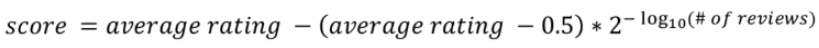

+ 평점 존재할 경우

In [49]:
def get_score(x):
    result = x['mean'] - (x['mean'] -0.5)*(math.pow(2, -np.log(x['count'])))
    return result

In [50]:
pop_df = interaction_df.groupby(item_id_var)[event].agg(['mean', 'count'])
pop_df = pd.DataFrame(pop_df.reset_index())
pop_df['score'] = pop_df.apply(get_score, axis=1)
pop_df = pop_df.sort_values('score', ascending=False)
pop_df['weight'] = pop_df['score'].apply(math.exp)

In [52]:
pop_list = pop_df.sample(n=10, weights='weight')[item_id_var].tolist()
pop_list

['1de0c711-042b-4b47-93d9-3a7d8d969ac6',
 'a01ee85c-f301-4e22-97e0-ca3065ddb19d',
 'df47e844-f0de-488b-b6eb-38753c204ae9',
 '98863ae7-9d5a-4b56-b3e9-3c6c053114e8',
 '84d6c26d-9760-49d8-854b-0a22becd8241',
 'ba131f5c-e3c7-4617-acbd-22c561c7cf97',
 '36a73f97-5107-4471-9609-f34235123c63',
 'c72257d4-430b-4eb7-9de3-28396e593381',
 '1bfbe5c7-6f02-4465-82f1-6083a4b302c0',
 'cfd9119f-ee29-4bc5-a08d-a58f471e7c73']

+ 평점 없을 경우

In [54]:
pop_df = interaction_df.groupby(item_id_var)[event].agg(['count'])
pop_df = pd.DataFrame(pop_df.reset_index())
pop_list = pop_list = pop_df.sample(n=10, weights='count')[item_id_var].tolist()

+ pop_df

In [55]:
pop_df = item_df[item_df[item_id_var].isin(pop_list)]
pop_df

,ITEM_ID,ITEM_NAME,CATEGORY_L1,STYLE,ITEM_DESCRIPTION,PRICE
440,f5aea4cc-13dc-492b-a744-27a5e3f718cf,Screwdriver,tools,screwdriver,Essential screwdriver for every craftperson,13.99
517,7af26050-056f-4855-ba8a-bcee48f0923d,Black Office Chair,furniture,chairs,Ideal black chair for your office,231.99
528,1dddc877-52ac-480c-b786-2dbd2be70c04,Visit Iceland,books,travel,Plan your next trip with this essential reference book on Iceland,12.99
674,5fd9f9b7-e6e4-468d-93b8-fa984f66cde3,Turkish Cuisine,books,cooking,Learn to cook Turkish cuisine with these easy recipes,15.99
954,6edbdde6-0791-4a53-ae92-b8aaba88753d,Chef Knife,housewares,kitchen,Incomparable for every kitchen,72.99
1042,dd9e97a6-4281-40a5-9048-fde7809623fb,Unequaled Cable,electronics,cable,This high quality cabling is unequaled for your electronics at home and on the go,13.99
1778,cee9e9a1-9949-42a9-92a6-4a4420fcc7a3,Lemon Jacket,apparel,jacket,Well-insulated jacket for women for all seasons,185.99
1840,1c770ee6-98d7-4820-a5e0-3e7abc165f8d,Light Gray Shirt,apparel,shirt,Matchless light gray dressy shirt for women,224.99
2294,28fd3ede-3381-419c-8c9d-3e6e907d7114,Pork,groceries,meat,Our pork is raised sustainably by our farmers,13.99
2300,6bd26ffc-9fae-447b-a23c-fcb14187302a,Glass Vase,homedecor,decorative,This glass vase is a must-have for your home decor,22.99


# **USER-BASED**

In [ ]:
matrix = interaction_df.pivot_table(index = user_id_var, columns = item_id_var, values=event)
matrix_norm =matrix.subtract(matrix.mean(axis=1), axis = 'rows')
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity= pd.DataFrame(user_similarity_cosine, index = matrix_norm.index, columns = matrix_norm.index)

In [ ]:
def make_user_based_df(user_similarity, matrix_norm, userid, num):
    user_similarity_drop = user_similarity.drop(index=userid) #userid 제외
    similar_users = user_similarity_drop[userid].sort_values(ascending=False)[:num] #user_similarity를 통해 자신과 비슷한 user 추출
    picked_userid = matrix_norm[matrix_norm.index == userid].dropna(axis=1, how='all') #자신이 선택했던 item 추출
    similar_user_items = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all') #비슷한 유저가 선택한 아이템 추출
    item_score = {}
    for i in similar_user_items.columns : 
        items_rating = similar_user_items[i]
        total, count = 0, 0
        for u in similar_users.index:
            if pd.isna(items_rating[u]) == False:
                score = similar_users[u] * items_rating[u]
                total += score
                count += 1
        item_score[i] = total / count
    print(item_score)
    item_score = pd.DataFrame(item_score.items(), columns = [item_id_var,'Predictions'])
    item_score_df = item_score.sort_values(by = 'Predictions', ascending=False).head(num)
    return item_score_df

In [ ]:
def perf_metric(interaction_df, user_similarity, matrix_norm, num):
    recommend_dfs = pd.DataFrame()
    
    #for USER_ID in tqdm.tqdm(interaction_df[user_id_var].unique()):
    for USER_ID in ['3156','332','3981']:
        recommend_df = make_user_based_df(user_similarity, matrix_norm, USER_ID, num)
      
        #상위 추천 item 중 이미 user가 선정했던 item 제외 후 추천 목록 추출
        recommend_df.loc[:, user_id_var] = USER_ID
        recommend_dfs = pd.concat([recommend_dfs, recommend_df], axis=0)
    return recommend_dfs